# Example: AnomalyDetector Usage
Shows how to use the AnomalyDetector class and plot the results. This includes:
1. Data Loading
2. Data format preparation
3. Training and prediction
4. Plotting
5. Evaluation of results
6. Root cause analysis using ARCANA

Get the dataset which is used in this notebook here: [CARE to Compare dataset](https://doi.org/10.5281/zenodo.14958989)

In [1]:
from energy_fault_detector.fault_detector import Config, FaultDetector
from energy_fault_detector.evaluation import Care2CompareDataset, CAREScore
from energy_fault_detector.utils.visualisation import plot_learning_curve, plot_score_with_threshold, plot_reconstruction

# Loading the data

In [2]:
# Specify the path to the data
data_path = '../../Care_To_Compare_v5'
c2c = Care2CompareDataset(path=data_path)

config = Config(config_filename='c2c_configs/windfarm_C.yaml')
# update features to exclude (counters) and angles for data preprocessing
c2c.update_c2c_config(config=config, wind_farm='C')

In [3]:
# event selection
event_id = 44
event_info = c2c.get_event_info(event_id=event_id)
event_info

asset_id                                                            44
event_id                                                            44
event_label                                                    anomaly
event_start                                        2023-08-03 14:00:00
event_start_id                                                   52704
event_end                                          2023-10-08 02:20:00
event_end_id                                                     62138
event_description    Valve in water cooling system was left in wron...
wind_farm                                                            C
Name: 15, dtype: object

# Prepare data format for anomaly detection

In [4]:
# load and split data into numerical sensor data and status_data
train_sensor_data, train_status, test_sensor_data, test_status = c2c.get_formatted_event_dataset(event_id=event_id, index_column='time_stamp')

train_sensor_data.shape, train_status.shape, test_sensor_data.shape, test_status.shape

((52560, 238), (52560,), (10443, 238), (10443,))

# Train the model and evaluate on the data

In [5]:
model = FaultDetector(config=config)
train_results = model.fit(sensor_data=train_sensor_data, normal_index=train_status, save_models=False)  # returns a dictionary
# save the model manually if needed by using:
# model.save_models(model_name='my_model')

2025-07-03 13:06:38,629 - fault_detection - INFO - Initialize models..
2025-07-03 13:06:39,032 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:06:39,545 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:06:41,362 - fault_detection - INFO - Train autoencoder.
1643/1643 [==============================] - 2s 1ms/step
2025-07-03 13:07:07,084 - fault_detection - INFO - Fit threshold on validation data
1643/1643 [==============================] - 1s 808us/step
2025-07-03 13:07:09,078 - fault_detection - INFO - Fit threshold.
2025-07-03 13:07:09,132 - fault_detection - INFO - Best F_0.5 score: 0.977, threshold: 4.20


In [6]:
train_results.model_path

# model_date: datetime of training (finished)
# model_path: where the model is saved (full path)
# train/val_recon_error: reconstruction error of the autoencoder, can be used to calculate the MSE

In [7]:
train_results.model_date, train_results.model_path

('20250703_130709', None)

In [8]:
predictions = model.predict(sensor_data=test_sensor_data)  # returns a dictionary

predictions.reconstruction

# recon_error: reconstruction error of the autoencoder
# reconstruction: reconstruction of the input data (rescaled to original scale)
# predicted_anomalies: dataframe with column indicating whether an anomaly is detected
# anomaly_score: dataframe with column containing the Anomaly Score
# bias_data: dataframe with ARCANA bias vector, if root cause analysis was performed
# arcana_losses: dataframe containing recorded ARCANA losses
# tracked_bias: List of recorded biases during ARCANA iterations


327/327 [==============================] - 0s 923us/step


,sensor_0_avg,sensor_1_avg,power_2_avg,sensor_3_avg,sensor_4_avg,power_5_avg,power_6_avg,sensor_7_avg,sensor_8_avg,sensor_9_avg,...,sensor_228_avg,sensor_229_avg,sensor_230_avg,sensor_231_avg,sensor_232_avg,sensor_233_avg,sensor_234_avg,wind_speed_236_avg,wind_speed_235_avg,wind_speed_237_avg
time_stamp,,,,,,,,,,,,,,,,,,,,,
2023-08-02 14:00:00,0.983075,0.000132,0.044939,36.205967,39.057243,0.024169,0.008709,31.140858,-14.851563,0.021176,...,32.977318,33.248085,531.399963,0.632615,0.570969,42.376812,42.850609,2.526348,2.606518,2.205301
2023-08-02 14:10:00,0.591013,-0.003445,0.048422,44.141106,27.678867,0.005456,0.003976,30.593010,-16.905693,0.035017,...,33.615509,33.132545,538.773987,0.497438,0.426810,41.761333,42.315880,1.735880,1.871471,1.801970
2023-08-02 14:20:00,-0.969567,-0.001660,0.033186,35.412079,35.931725,0.001399,-0.003318,31.198793,-11.588895,0.020694,...,34.654907,34.284138,538.969849,0.858318,0.804719,42.135292,42.786034,1.886430,1.994382,1.898526
2023-08-02 14:30:00,3.492802,-0.004185,0.080089,39.036411,37.264259,0.047929,0.036983,30.715004,-16.409924,0.045064,...,32.220757,32.141220,541.245483,0.359283,0.275743,41.298042,41.832035,2.175905,2.084608,1.815044
2023-08-02 14:40:00,2.531002,-0.001636,0.063570,37.588249,40.227486,0.043678,0.026107,30.929922,-14.772250,0.031814,...,32.095310,32.356262,534.925171,0.504951,0.430985,41.633045,42.149761,2.546220,2.495702,2.090817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-14 01:40:00,45.455524,0.007012,0.536658,83.769463,0.388931,0.508920,0.514726,26.508907,162.076538,0.001748,...,40.474857,40.516346,524.124634,3.739038,3.760212,42.651707,42.989388,8.472232,8.189131,8.512582
2023-10-14 01:50:00,39.184521,0.004794,0.464695,83.705421,0.486487,0.438143,0.442136,26.411692,155.474335,0.002566,...,40.991856,41.007877,524.669495,3.743241,3.758979,43.099720,43.459820,8.136012,7.874740,8.120282
2023-10-14 02:00:00,45.944130,0.006747,0.545717,83.244949,0.502671,0.516872,0.521662,26.472918,161.169617,0.003036,...,40.461655,40.478218,524.926880,3.745550,3.766693,42.728172,43.010532,8.386470,8.116540,8.420117


# How to plot the evaluation results
1. Model training loss
2. Plotting the anomaly score including model threshold
3. Adding anomaly markers in the anomaly score plot

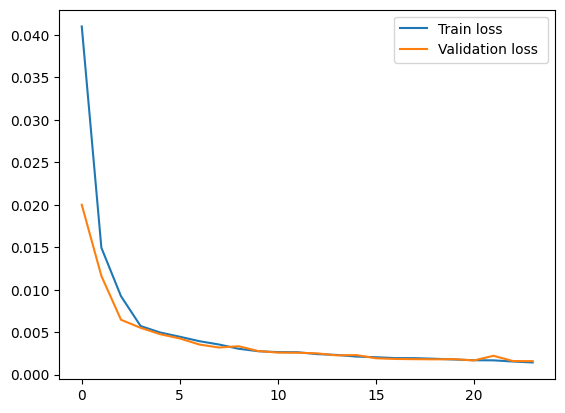

In [9]:
fig, ax = plot_learning_curve(model)

327/327 [==============================] - 0s 1ms/step


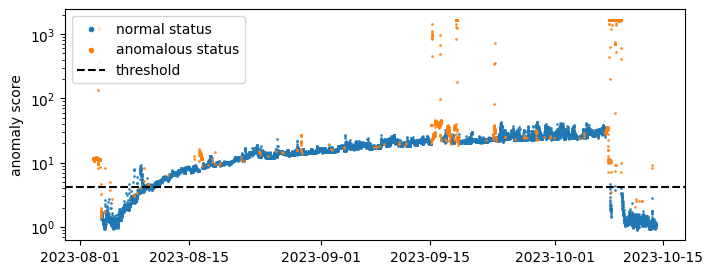

In [10]:
fig, ax = plot_score_with_threshold(model=model, data=test_sensor_data, normal_index=test_status)
ax.set_yscale('log')

327/327 [==============================] - 0s 740us/step


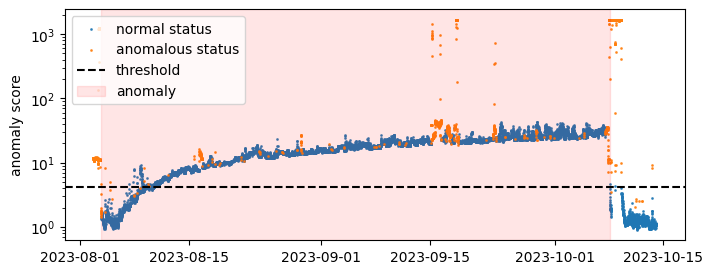

In [11]:
fig, ax = plot_score_with_threshold(model=model, data=test_sensor_data, normal_index=test_status)
ax.set_yscale('log')
ax.axvspan(event_info['event_start'], event_info['event_end'], alpha=0.1, color='red', label='anomaly')
ax.legend(loc='upper left')

In [12]:
c2c.feature_descriptions['C']

,sensor_name,statistics_type,description,unit,is_angle,is_counter
0,sensor_0,"maximum,minimum,std_dev,average","ABB-LS Input K1, IL1",A,False,False
1,sensor_1,"maximum,minimum,std_dev,average",Generator acceleration,rpm/s,False,False
2,power_2,"average,maximum,std_dev,minimum",ABB-LS Active Power,kW,False,False
3,sensor_3,"average,maximum,minimum,std_dev",Active power aeration motor A,%,False,False
4,sensor_4,"average,maximum,minimum,std_dev",Active power aeration motor B,%,False,False
...,...,...,...,...,...,...
233,sensor_233,"average,maximum,minimum,std_dev",Cooling water temp. generator outlet 1,Celsius,False,False
234,sensor_234,"average,maximum,minimum,std_dev",Cooling water temp. generator outlet 2,Celsius,False,False
235,wind_speed_235,"average,maximum,minimum,std_dev",Wind speed 1,m/s,False,False
236,wind_speed_236,"average,maximum,minimum,std_dev",Wind speed 1+2,m/s,False,False


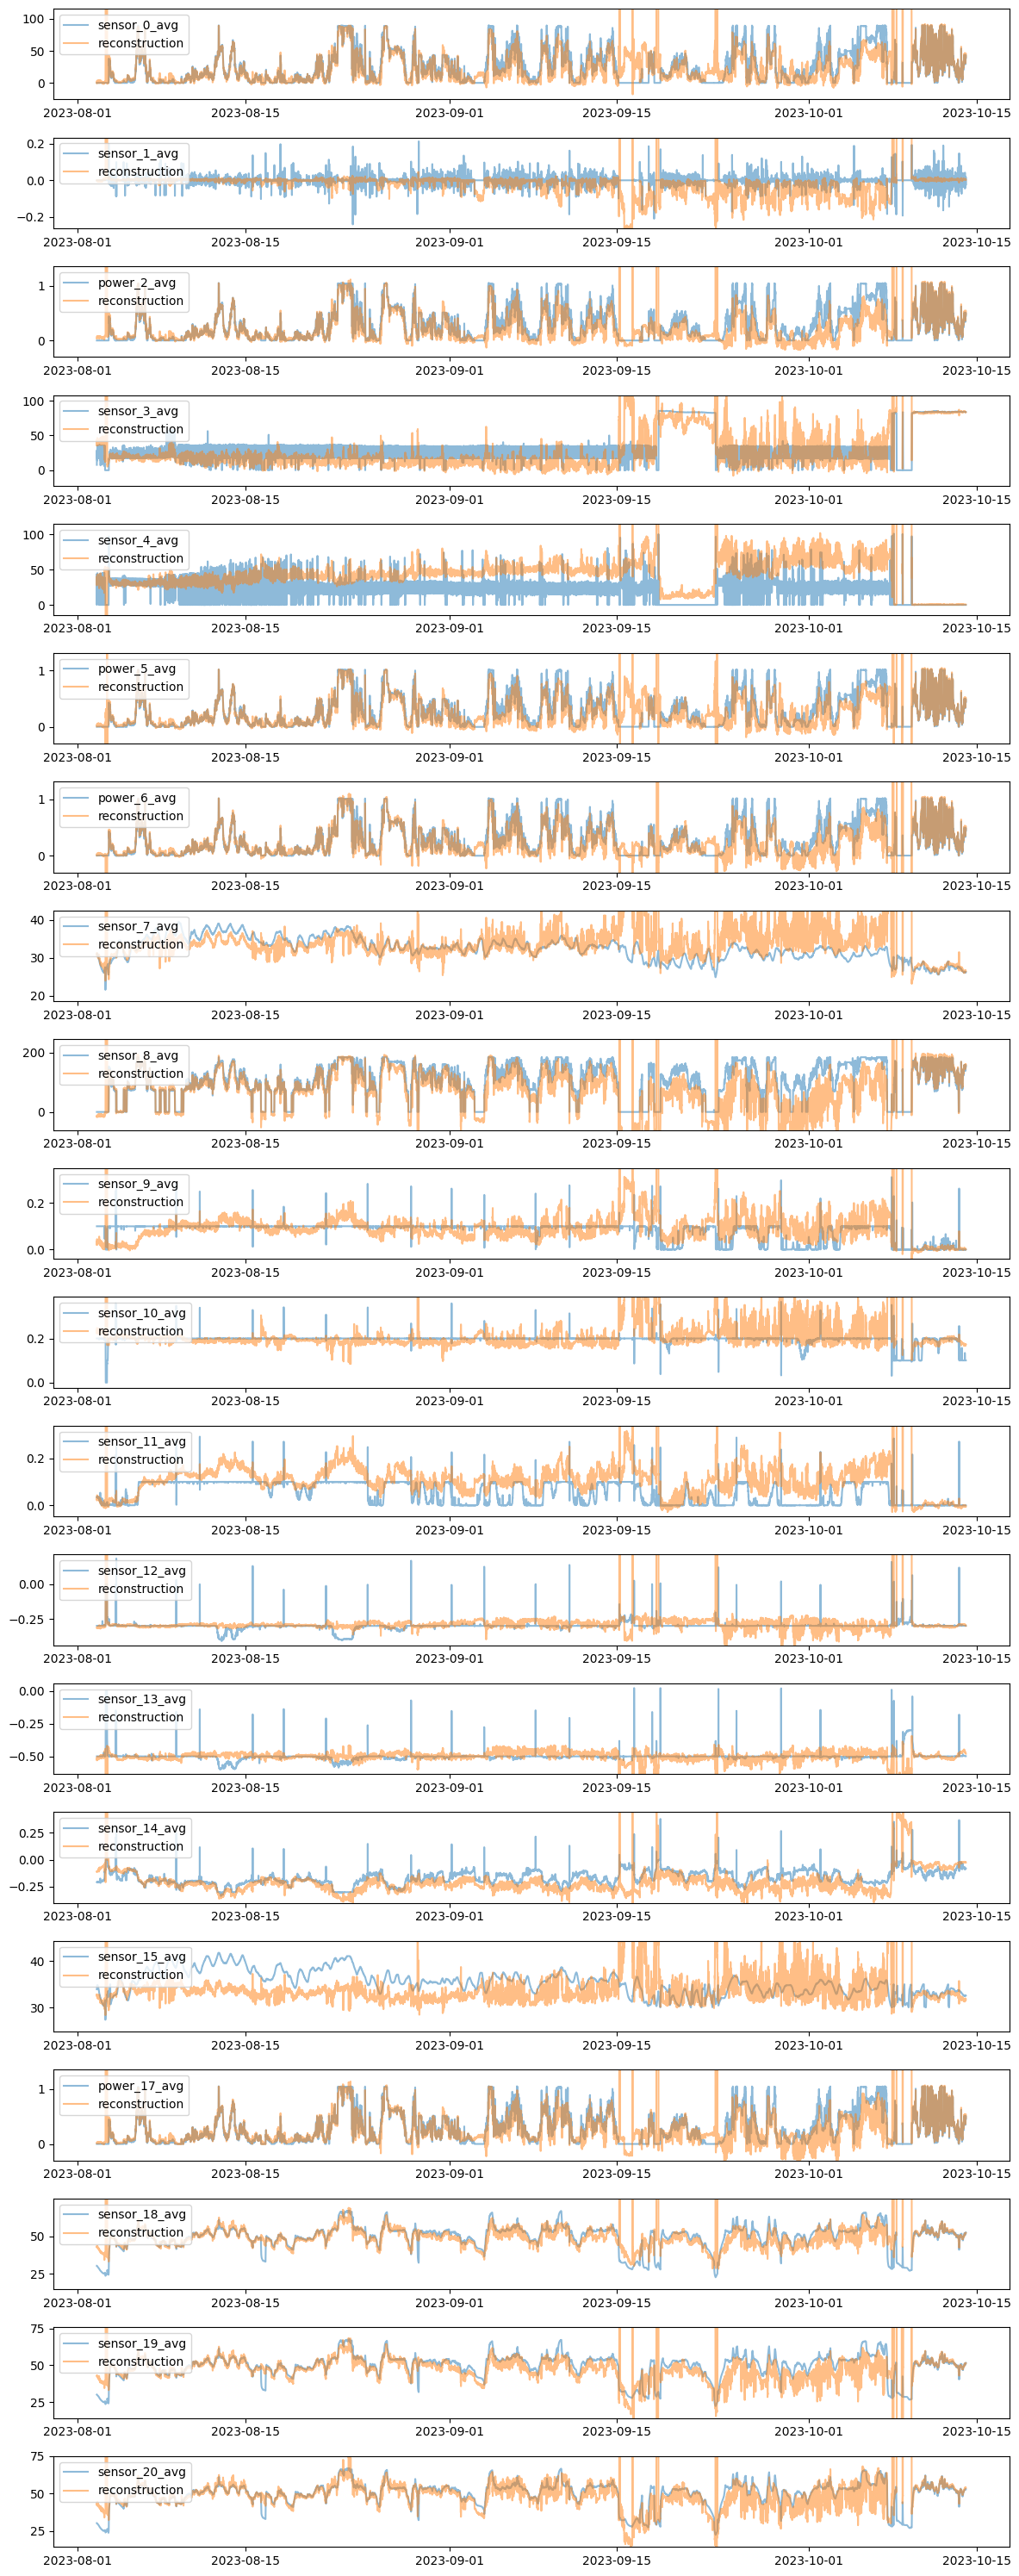

In [13]:
# Plot reconstruction of the first couple of features
fig, ax = plot_reconstruction(test_sensor_data, predictions.reconstruction, features_to_plot=predictions.reconstruction.columns[:20])

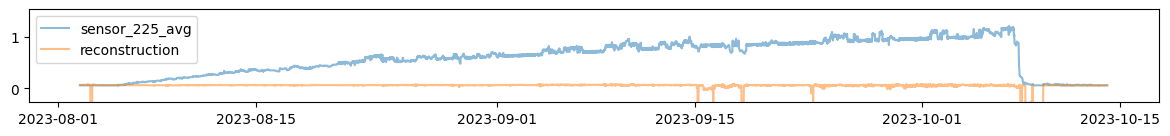

In [14]:
# Plot the feature with the anomalous behaviour
fig, ax = plot_reconstruction(test_sensor_data, predictions.reconstruction, features_to_plot=['sensor_225_avg'])

## Evaluate results

This section show cases two examples for result evaluation:
1. Evaluating the given prediction and ground truth with the Fbeta Score
2. Plotting the Confusion matrix

In [15]:
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay

In [16]:
# create boolean series with the ground truth for this dataset
ground_truth = CAREScore.create_ground_truth(
    event_start=event_info['event_start'],
    event_end=event_info['event_end'],
    event_label=event_info['event_label'],
    normal_index=test_status
)

predicted_anomalies = predictions.predicted_anomalies['anomaly']

fbeta_score(y_true=ground_truth, y_pred=predicted_anomalies, beta=1)

0.9538132191597538

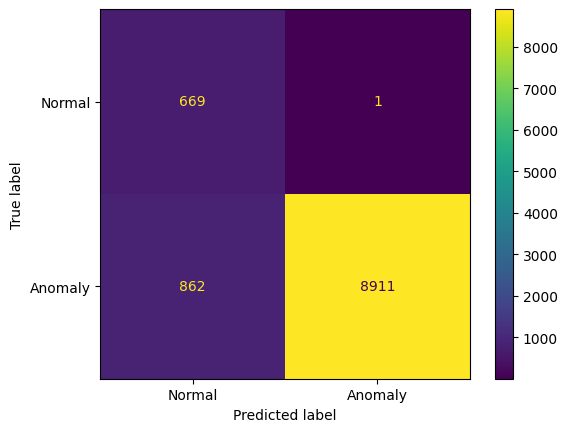

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix(ground_truth, predicted_anomalies, labels=[False, True]),
                              display_labels=["Normal", "Anomaly"],)
disp.plot()

# Root Cause Analysis with Arcana

In [18]:
from energy_fault_detector.utils.analysis import create_events

# Find anomaly events
event_meta_data, event_data_list = create_events(sensor_data=test_sensor_data, boolean_information=predicted_anomalies, min_event_length=20)
event_meta_data

,start,end,duration
0,2023-08-02 14:00:00,2023-08-03 14:00:00,1 days 00:00:00
1,2023-08-09 09:40:00,2023-08-09 14:40:00,0 days 05:00:00
2,2023-08-10 09:00:00,2023-10-08 02:20:00,58 days 17:20:00
3,2023-10-08 07:00:00,2023-10-08 19:30:00,0 days 12:30:00
4,2023-10-08 19:50:00,2023-10-09 14:00:00,0 days 18:10:00


In [19]:
# Specify Arcana parameters in the config
rca_config_dict = model.config.config_dict
rca_config_dict['root_cause_analysis'] = {'alpha': 0.5,  # weighting for the loss combination in Arcana. 0.5 means equal weighting between reconstruction and regularization
                                          'init_x_bias': 'recon',  # initialization method of x_bias. 'recon' means starting with the reconstruction error
                                          'num_iter': 3000,  # number of iterations for gradient based optimization of x_bias. Visualize the convergence behavior with the loss plots from next section to identify the optimal number of iterations.
                                          'verbose': True  # logs loss every 50th iteration
                                          }
model.config.update_config(new_config_dict=rca_config_dict)

In [20]:
# Analyze the longest event
longest_event_index = event_meta_data[event_meta_data['duration'] == event_meta_data['duration'].max()].index[0]
event_data = event_data_list[longest_event_index]
arcana_bias, arcana_losses, tracked_bias = model.run_root_cause_analysis(sensor_data=event_data, track_losses=True, track_bias=True)

2025-07-03 13:07:16,079 - fault_detection - INFO - 0 Combined Loss: 8.72
2025-07-03 13:07:17,493 - fault_detection - INFO - 50 Combined Loss: 8.59
2025-07-03 13:07:18,758 - fault_detection - INFO - 100 Combined Loss: 8.48
2025-07-03 13:07:20,161 - fault_detection - INFO - 150 Combined Loss: 8.38
2025-07-03 13:07:21,838 - fault_detection - INFO - 200 Combined Loss: 8.28
2025-07-03 13:07:23,232 - fault_detection - INFO - 250 Combined Loss: 8.20
2025-07-03 13:07:25,034 - fault_detection - INFO - 300 Combined Loss: 8.12
2025-07-03 13:07:26,674 - fault_detection - INFO - 350 Combined Loss: 8.05
2025-07-03 13:07:27,931 - fault_detection - INFO - 400 Combined Loss: 7.99
2025-07-03 13:07:29,293 - fault_detection - INFO - 450 Combined Loss: 7.93
2025-07-03 13:07:30,642 - fault_detection - INFO - 500 Combined Loss: 7.87
2025-07-03 13:07:32,041 - fault_detection - INFO - 550 Combined Loss: 7.81
2025-07-03 13:07:33,415 - fault_detection - INFO - 600 Combined Loss: 7.76
2025-07-03 13:07:34,781 - fa

In [21]:
from energy_fault_detector.root_cause_analysis.arcana_utils import calculate_mean_arcana_importances

# compute ARCANA importances from the ARCANA bias
importances = calculate_mean_arcana_importances(bias_data=arcana_bias)

The Arcana-bias represents a regularized estimate for the difference between the input sensor data and a version of the input which has a low reconstruction error.
Intuitively this means that the bias represents the difference between the input data and a normal version of the input data according to the used autoencoder model.
Feature-Importances can be derived from the Arcana-bias and they give an indication of which input features contributed the most to reconstruction errors. Thus, they represent the data features which caused anomalous behavior according to the used autoencoder model.

## Primary visualisation of root cause analysis results

The shown visualizations in this section are useful for working with Arcana for root cause analysis

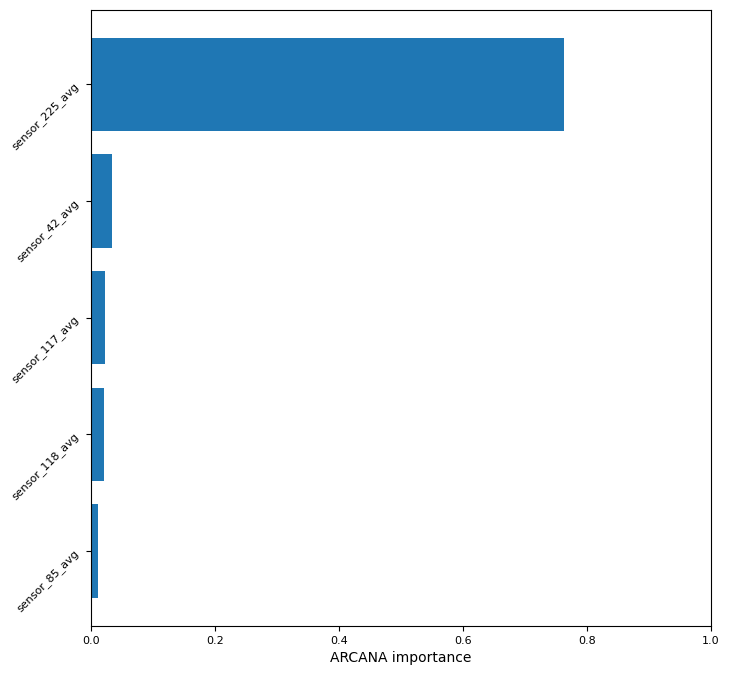

In [22]:
from energy_fault_detector.utils.visualisation import plot_arcana_mean_importances

_ = plot_arcana_mean_importances(importances=importances, top_n_features=5)

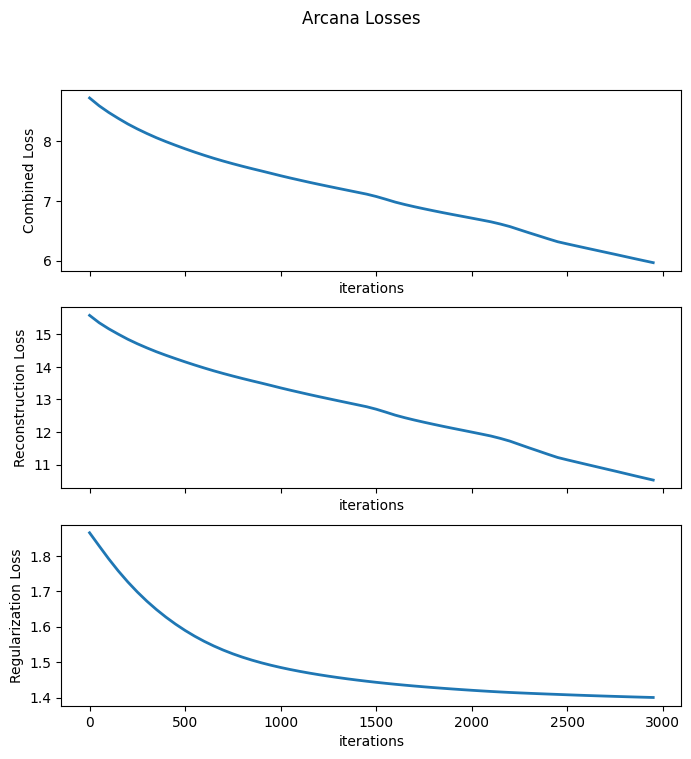

In [23]:
from energy_fault_detector.utils.visualisation import plot_arcana_losses

plot_arcana_losses(losses=arcana_losses)

## Secondary visualisation of root cause analysis results

Secondary visualisations are mainly useful for analyzing the way in which Arcana calculates the final bias and feature importances.

2025-07-03 13:11:04,532 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


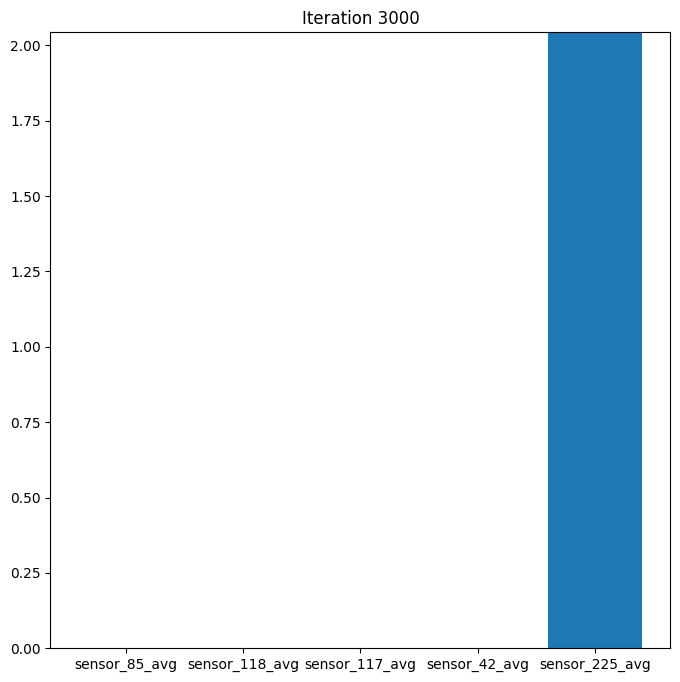

In [29]:
from energy_fault_detector.utils.visualisation import animate_bias
from datetime import datetime

# select a time stamp which you want to inspect
time_stamp = datetime(year=2023, month=10, day=1, hour=1, minute=40)
top_5_features = list(importances.index[-5:])
# Animate the bias evolution for the features with the top 5 importances in one time stamp
bias_list = [bias.loc[time_stamp] for bias in tracked_bias]
animate_bias(bias_list=bias_list, selected_column_names=top_5_features)

# Plotting the input correction process of ARCANA

2025-07-03 13:11:08,975 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


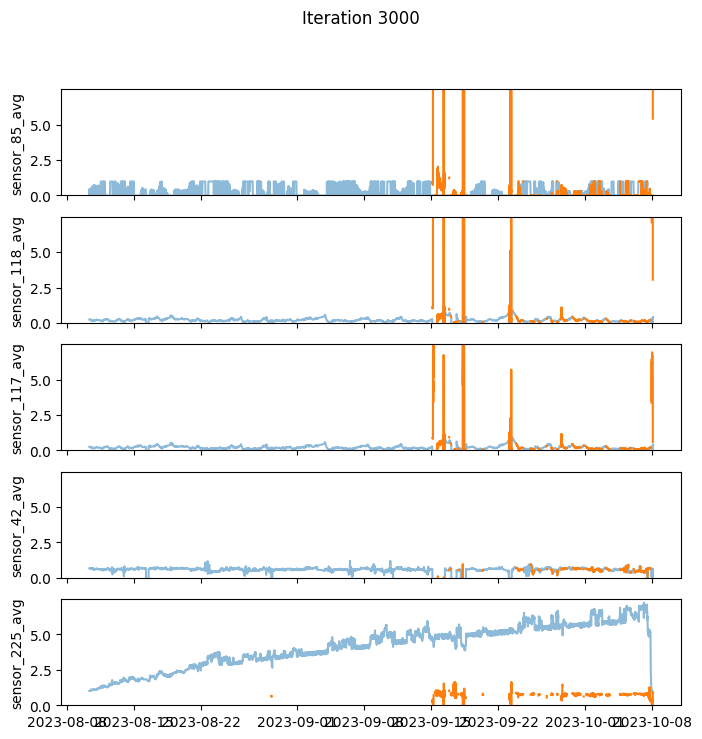

In [30]:
from energy_fault_detector.utils.visualisation import animate_corrected_input
prepped_test_data = model.data_preprocessor.transform(test_sensor_data).loc[event_data.index]
animate_corrected_input(corrected_list=[prepped_test_data + bias for bias in tracked_bias],
                        initial_input=prepped_test_data,
                        selected_column_names=top_5_features)